In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## The Basics

Let's define the p-value:

> A standard definition of the p-value is that it is "the probability, computed assuming that H0 is true, that the test statistic would take a value as extreme or more extreme than that actually observed."- [Murdoch et al. (2008)](https://www.tandfonline.com/doi/abs/10.1198/000313008X332421?journalCode=utas20)

But what does that actually mean? Contrary to common assumptions, the p-value is not equivalent to the probability of H0 being true or the probability of a type I error. 

A way to intuit what a p-value represents is to understand that a p-value is a *random variable* and its *distribution* under the null hypothesis is uniform. In other words, under the null hypothesis (i.e. "no effect") the distribution of p-values looks like:

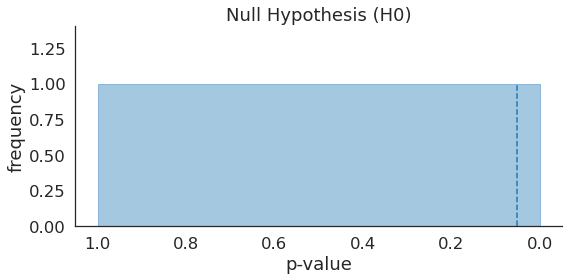

In [2]:
from scipy.stats import uniform

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot.
x = np.linspace(0,1,11)
ax.fill_between(x, 0, uniform.pdf(x), color='#1f77b4', alpha=0.4)
ax.vlines(0.05,0,1,linestyle='--')
ax.set(xlabel='p-value', ylim=(0,1.4), ylabel='frequency', title='Null Hypothesis (H0)')
ax.invert_xaxis()
sns.despine()
plt.tight_layout()

But you don't have to take my word for it. Let's demonstrate that this is in fact the case. Let's perform a common statistical test, the one-sample t-test, randomly simulating data under the null hypothesis, H0: $\mu=0$.

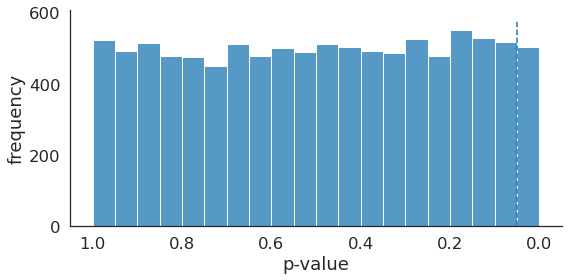

In [3]:
from scipy.stats import ttest_1samp
np.random.seed(47404)

## Define parameters.
n_sim = 10000
n_samp = 100
mu = 0
sd = 1

## Main loop.
pvals = []
for _ in range(n_sim):
    
    ## Simulate data.
    x = np.random.normal(mu, sd, n_samp)
    
    ## Compute one-sample t-test.
    t, p = ttest_1samp(x, 0)
    
    ## Store result.
    pvals.append(p)
    
## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.histplot(pvals, bins=np.linspace(0,1,21), kde=False, ax=ax)
ax.vlines(0.05,*ax.get_ylim(),linestyle='--')
ax.set(xlabel='p-value', ylabel='frequency')
ax.invert_xaxis()
sns.despine()
plt.tight_layout()

And what about when we sample from the alternative hypothesis, i.e. H1: $\mu \neq 0$? Now, the distribution of p-values is contingent on three factors: the mean, the variance (noise), and the number of samples. This follows from the definition of the one-sample t-test statistic:

$$ t = \frac{x - \mu}{\sigma / \sqrt{n}} $$

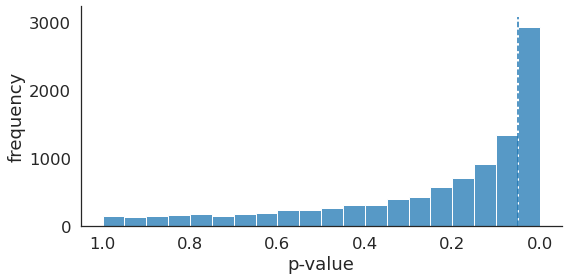

In [4]:
from scipy.stats import ttest_1samp
np.random.seed(47404)

## Define parameters.
n_sim = 10000
n_samp = 10
mu = 0.5
sd = 1

## Main loop.
pvals = []
for _ in range(n_sim):
    
    ## Simulate data.
    x = np.random.normal(mu, sd, n_samp)
    
    ## Compute one-sample t-test.
    t, p = ttest_1samp(x, 0)
    
    ## Store result.
    pvals.append(p)
    
## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.histplot(pvals, bins=np.linspace(0,1,21), kde=False, ax=ax)
ax.vlines(0.05,*ax.get_ylim(),linestyle='--')
ax.set(xlabel='p-value', ylabel='frequency')
ax.invert_xaxis()
sns.despine()
plt.tight_layout()

In frequentist hypothesis testing, we are trying to infer the likelihood of our effect being drawn from the null or alternative hypothesis distributions. Our inference is necessarily constrained then by our assumptions about the parameters governing the alternative hypothesis distribution. We define our $\alpha$-level according to our tolerance of the risk of false positives (Type I error) *under the null hypothesis*. We also optimize our experiments to increase statistical power in order to minimize the risk of false negatives (Type II error). Importantly, any one single experiment cannot possibly tell us if our effect is drawn from the null or alternative hypothesis! Replication(s) is always needed to be confident to an effect is drawn from the alternative hypothesis.

## Permutation Testing

Great, ok, so now that we have established that p-values are random variables, let's discuss how permutation testing relates to this. Simply put, permutation testing is a method for approximating p-values.

### Permutation 2-sample (independent)

Scipy: t = -3.411, p = 0.000943
Permutation: t = -3.411, p = 0.001700


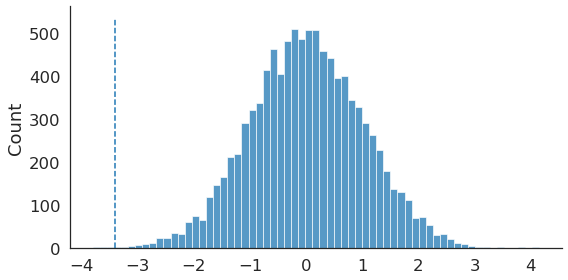

In [5]:
from scipy.stats import ttest_ind
np.random.seed(47404)

## Define parameters.
n_perm = 10000
n_samp_per_group = 50
mu = [0.0, 1.0]
sd = 1

## Simulate data.
x = np.concatenate([np.random.normal(mu[0], sd, n_samp_per_group),
                    np.random.normal(mu[1], sd, n_samp_per_group)])
ix = np.concatenate([np.zeros(n_samp_per_group), np.ones(n_samp_per_group)])

## Compute true statistic.
t, p = ttest_ind(x[ix==0], x[ix==1])
print('Scipy: t = %0.3f, p = %0.6f' %(t,p))

## Main loop.
tdist, p = [], 1
for _ in range(n_perm):
    
    ## Shuffle group membership.
    np.random.shuffle(ix)
    
    ## Compute null statistic.
    t_null, _ = ttest_ind(x[ix==0], x[ix==1])
    tdist.append(t_null)
    
    ## Test if greater than observed.
    if np.abs(t_null) > np.abs(t): p += 1
        
## Normalize.
p /= n_perm + 1
print('Permutation: t = %0.3f, p = %0.6f' %(t,p))

## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.histplot(tdist, kde=False, ax=ax)
ax.vlines(t, *ax.get_ylim(), linestyle='--')
sns.despine()
plt.tight_layout()

### Permutation 1-sample (sign-flip)

Scipy: t = 0.171, p = 0.864861
Permutation: t = 0.171, p = 0.866913


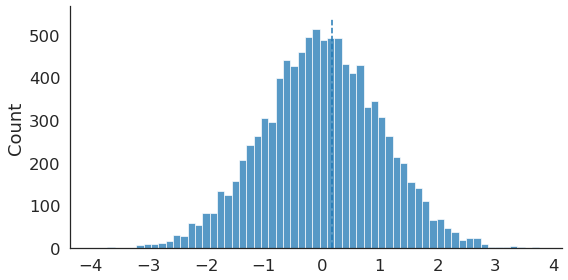

In [6]:
from scipy.stats import ttest_1samp
np.random.seed(47404)

## Define parameters.
n_sim = 10000
n_samp = 100
mu = 0
sd = 1

## Simulate data.
x = np.random.normal(mu, sd, n_samp)

## Compute true statistic.
t, p = ttest_1samp(x, 0)
print('Scipy: t = %0.3f, p = %0.6f' %(t,p))
    
## Main loop.
tdist, p = [], 1
for _ in range(n_perm):
    
    ## Randomly permute sign.
    sign_flip = np.sign(np.random.normal(size=n_samp))
    
    ## Compute null statistic.
    t_null, _ = ttest_1samp(x * sign_flip, 0)
    tdist.append(t_null)
    
    ## Test if greater than observed.
    if np.abs(t_null) > np.abs(t): p += 1
        
## Normalize.
p /= n_perm + 1
print('Permutation: t = %0.3f, p = %0.6f' %(t,p))

## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.histplot(tdist, kde=False, ax=ax)
ax.vlines(t, *ax.get_ylim(), linestyle='--')
sns.despine()
plt.tight_layout()

### Permutation 2-sample (dependent)

Scipy: t = -7.125, p = 0.000000
Permutation: t = -7.125, p = 0.000100


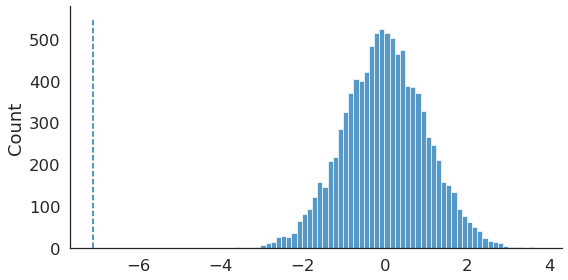

In [7]:
from scipy.stats import ttest_rel
np.random.seed(47404)

## Define parameters.
n_perm = 10000
n_samp = 100
mu = [0.0, 1.0]
sd = 1

## Simulate data.
random_intercepts = np.random.normal(size=n_samp)
x = np.zeros((2,n_samp))
for i in range(2): x[i] += np.random.normal(mu[i], sd, n_samp) + random_intercepts
    
## Compute true statistic.
t, p = ttest_rel(*x)
print('Scipy: t = %0.3f, p = %0.6f' %(t,p))

## Main loop.
tdist, p = [], 1
for _ in range(n_perm):
    
    ## Shuffle within an individual.
    xs = np.apply_along_axis(np.random.permutation, 0, x)
    
    ## Compute null statistic.
    t_null, _ = ttest_rel(*xs)
    tdist.append(t_null)
    
    ## Test if greater than observed.
    if np.abs(t_null) > np.abs(t): p += 1
        
## Normalize.
p /= n_perm + 1
print('Permutation: t = %0.3f, p = %0.6f' %(t,p))

## Plot.
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.histplot(tdist, kde=False, ax=ax)
ax.vlines(t, *ax.get_ylim(), linestyle='--')
sns.despine()
plt.tight_layout()

## Appendix

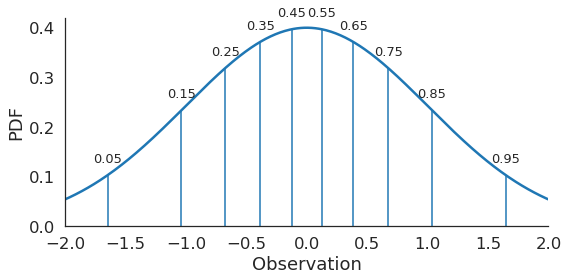

In [8]:
from scipy.stats import norm

## Initialize normal distribution.
N = norm(0, 1)

## Define PDF.
x = np.linspace(-5,5,1001)
y = N.pdf(x)

## Define PPF.
alpha = np.arange(0.05, 1, 0.1)
z = N.ppf(alpha)

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(x, y, lw=2.5)
ax.vlines(z, np.zeros_like(z), N.pdf(z))
for i,j,k in zip(z,N.pdf(z),alpha): ax.text(i,j+0.02,'%0.2f' %k, ha='center', va='bottom', fontsize=13)
ax.set(xlim=(-2,2), xlabel='Observation', ylim=(0), ylabel='PDF')
sns.despine()
plt.tight_layout()